# Kuramoto Model of Coupled Oscillators

## Introduction

The **Kuramoto model** is a mathematical framework for describing synchronization phenomena in large populations of coupled oscillators. Introduced by Yoshiki Kuramoto in 1975, this model has become a cornerstone in the study of collective behavior in complex systems, with applications ranging from neuroscience and cardiac pacemakers to power grids and chemical reactions.

## Mathematical Formulation

### The Basic Model

Consider a system of $N$ phase oscillators, where the $i$-th oscillator has phase $\theta_i(t)$ and natural frequency $\omega_i$. The Kuramoto model describes the evolution of these phases through the following coupled differential equations:

$$\frac{d\theta_i}{dt} = \omega_i + \frac{K}{N} \sum_{j=1}^{N} \sin(\theta_j - \theta_i)$$

where:
- $\theta_i$ is the phase of the $i$-th oscillator
- $\omega_i$ is the natural frequency of the $i$-th oscillator
- $K \geq 0$ is the coupling strength
- $N$ is the total number of oscillators

### Order Parameter

The degree of synchronization is quantified by the **complex order parameter**:

$$r e^{i\psi} = \frac{1}{N} \sum_{j=1}^{N} e^{i\theta_j}$$

where:
- $r \in [0, 1]$ measures the **coherence** of the population (degree of synchronization)
- $\psi$ represents the **mean phase** of the oscillator ensemble

When $r = 0$, the oscillators are completely desynchronized (phases uniformly distributed). When $r = 1$, all oscillators are perfectly synchronized (all phases identical).

### Critical Coupling Strength

For a population with natural frequencies drawn from a symmetric, unimodal distribution $g(\omega)$, a phase transition occurs at a critical coupling strength:

$$K_c = \frac{2}{\pi g(0)}$$

For $K < K_c$, the system remains incoherent ($r = 0$). For $K > K_c$, partial synchronization emerges with:

$$r \approx \sqrt{\frac{K - K_c}{K}}$$

## Physical Interpretation

The coupling term $\sin(\theta_j - \theta_i)$ represents the tendency of oscillator $i$ to align its phase with oscillator $j$:
- When $\theta_j > \theta_i$: positive contribution accelerates oscillator $i$
- When $\theta_j < \theta_i$: negative contribution decelerates oscillator $i$

This all-to-all (mean-field) coupling creates a competition between the natural frequency dispersion (promoting disorder) and the coupling strength (promoting order).

## Implementation

We will simulate the Kuramoto model and investigate:
1. Time evolution of individual oscillator phases
2. Evolution of the order parameter for different coupling strengths
3. The synchronization phase transition

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
def kuramoto_ode(theta, t, omega, K, N):
    """
    Compute the time derivative of phases for the Kuramoto model.
    
    Parameters:
    -----------
    theta : array
        Current phases of all oscillators
    t : float
        Current time (unused, required by odeint)
    omega : array
        Natural frequencies of oscillators
    K : float
        Coupling strength
    N : int
        Number of oscillators
        
    Returns:
    --------
    dtheta_dt : array
        Time derivatives of phases
    """
    # Compute pairwise phase differences efficiently using broadcasting
    phase_diff = theta - theta[:, np.newaxis]  # theta_i - theta_j
    coupling = np.sum(np.sin(-phase_diff), axis=1)  # sum_j sin(theta_j - theta_i)
    
    dtheta_dt = omega + (K / N) * coupling
    return dtheta_dt


def compute_order_parameter(theta):
    """
    Compute the Kuramoto order parameter.
    
    Parameters:
    -----------
    theta : array
        Phases of oscillators (can be 1D or 2D with time as first axis)
        
    Returns:
    --------
    r : float or array
        Magnitude of order parameter (coherence)
    psi : float or array
        Mean phase
    """
    complex_order = np.mean(np.exp(1j * theta), axis=-1)
    r = np.abs(complex_order)
    psi = np.angle(complex_order)
    return r, psi

## Simulation Parameters

We set up a population of oscillators with natural frequencies drawn from a Lorentzian (Cauchy) distribution:

$$g(\omega) = \frac{\gamma}{\pi[(\omega - \omega_0)^2 + \gamma^2]}$$

For this distribution centered at $\omega_0 = 0$ with width $\gamma$, the critical coupling is $K_c = 2\gamma$.

In [3]:
# Simulation parameters
N = 100  # Number of oscillators
gamma = 0.5  # Width of frequency distribution
K_c = 2 * gamma  # Critical coupling strength

# Natural frequencies from Lorentzian distribution
omega = np.random.standard_cauchy(N) * gamma

# Clip extreme frequencies for numerical stability
omega = np.clip(omega, -5*gamma, 5*gamma)

# Initial phases uniformly distributed
theta0 = np.random.uniform(0, 2*np.pi, N)

# Time span
t_max = 50
t = np.linspace(0, t_max, 1000)

print(f"Number of oscillators: {N}")
print(f"Frequency distribution width (γ): {gamma}")
print(f"Critical coupling strength (K_c): {K_c}")

Number of oscillators: 100
Frequency distribution width (γ): 0.5
Critical coupling strength (K_c): 1.0


## Phase Evolution for Different Coupling Strengths

We compare the dynamics below ($K < K_c$), at ($K = K_c$), and above ($K > K_c$) the critical coupling.

In [4]:
# Different coupling strengths to investigate
K_values = [0.5 * K_c, K_c, 2.0 * K_c, 4.0 * K_c]
labels = [f'K = {k:.2f} ({k/K_c:.1f}K_c)' for k in K_values]

# Store results
results = []
order_params = []

for K in K_values:
    # Solve ODEs
    theta = odeint(kuramoto_ode, theta0, t, args=(omega, K, N))
    results.append(theta)
    
    # Compute order parameter over time
    r, psi = compute_order_parameter(theta)
    order_params.append(r)

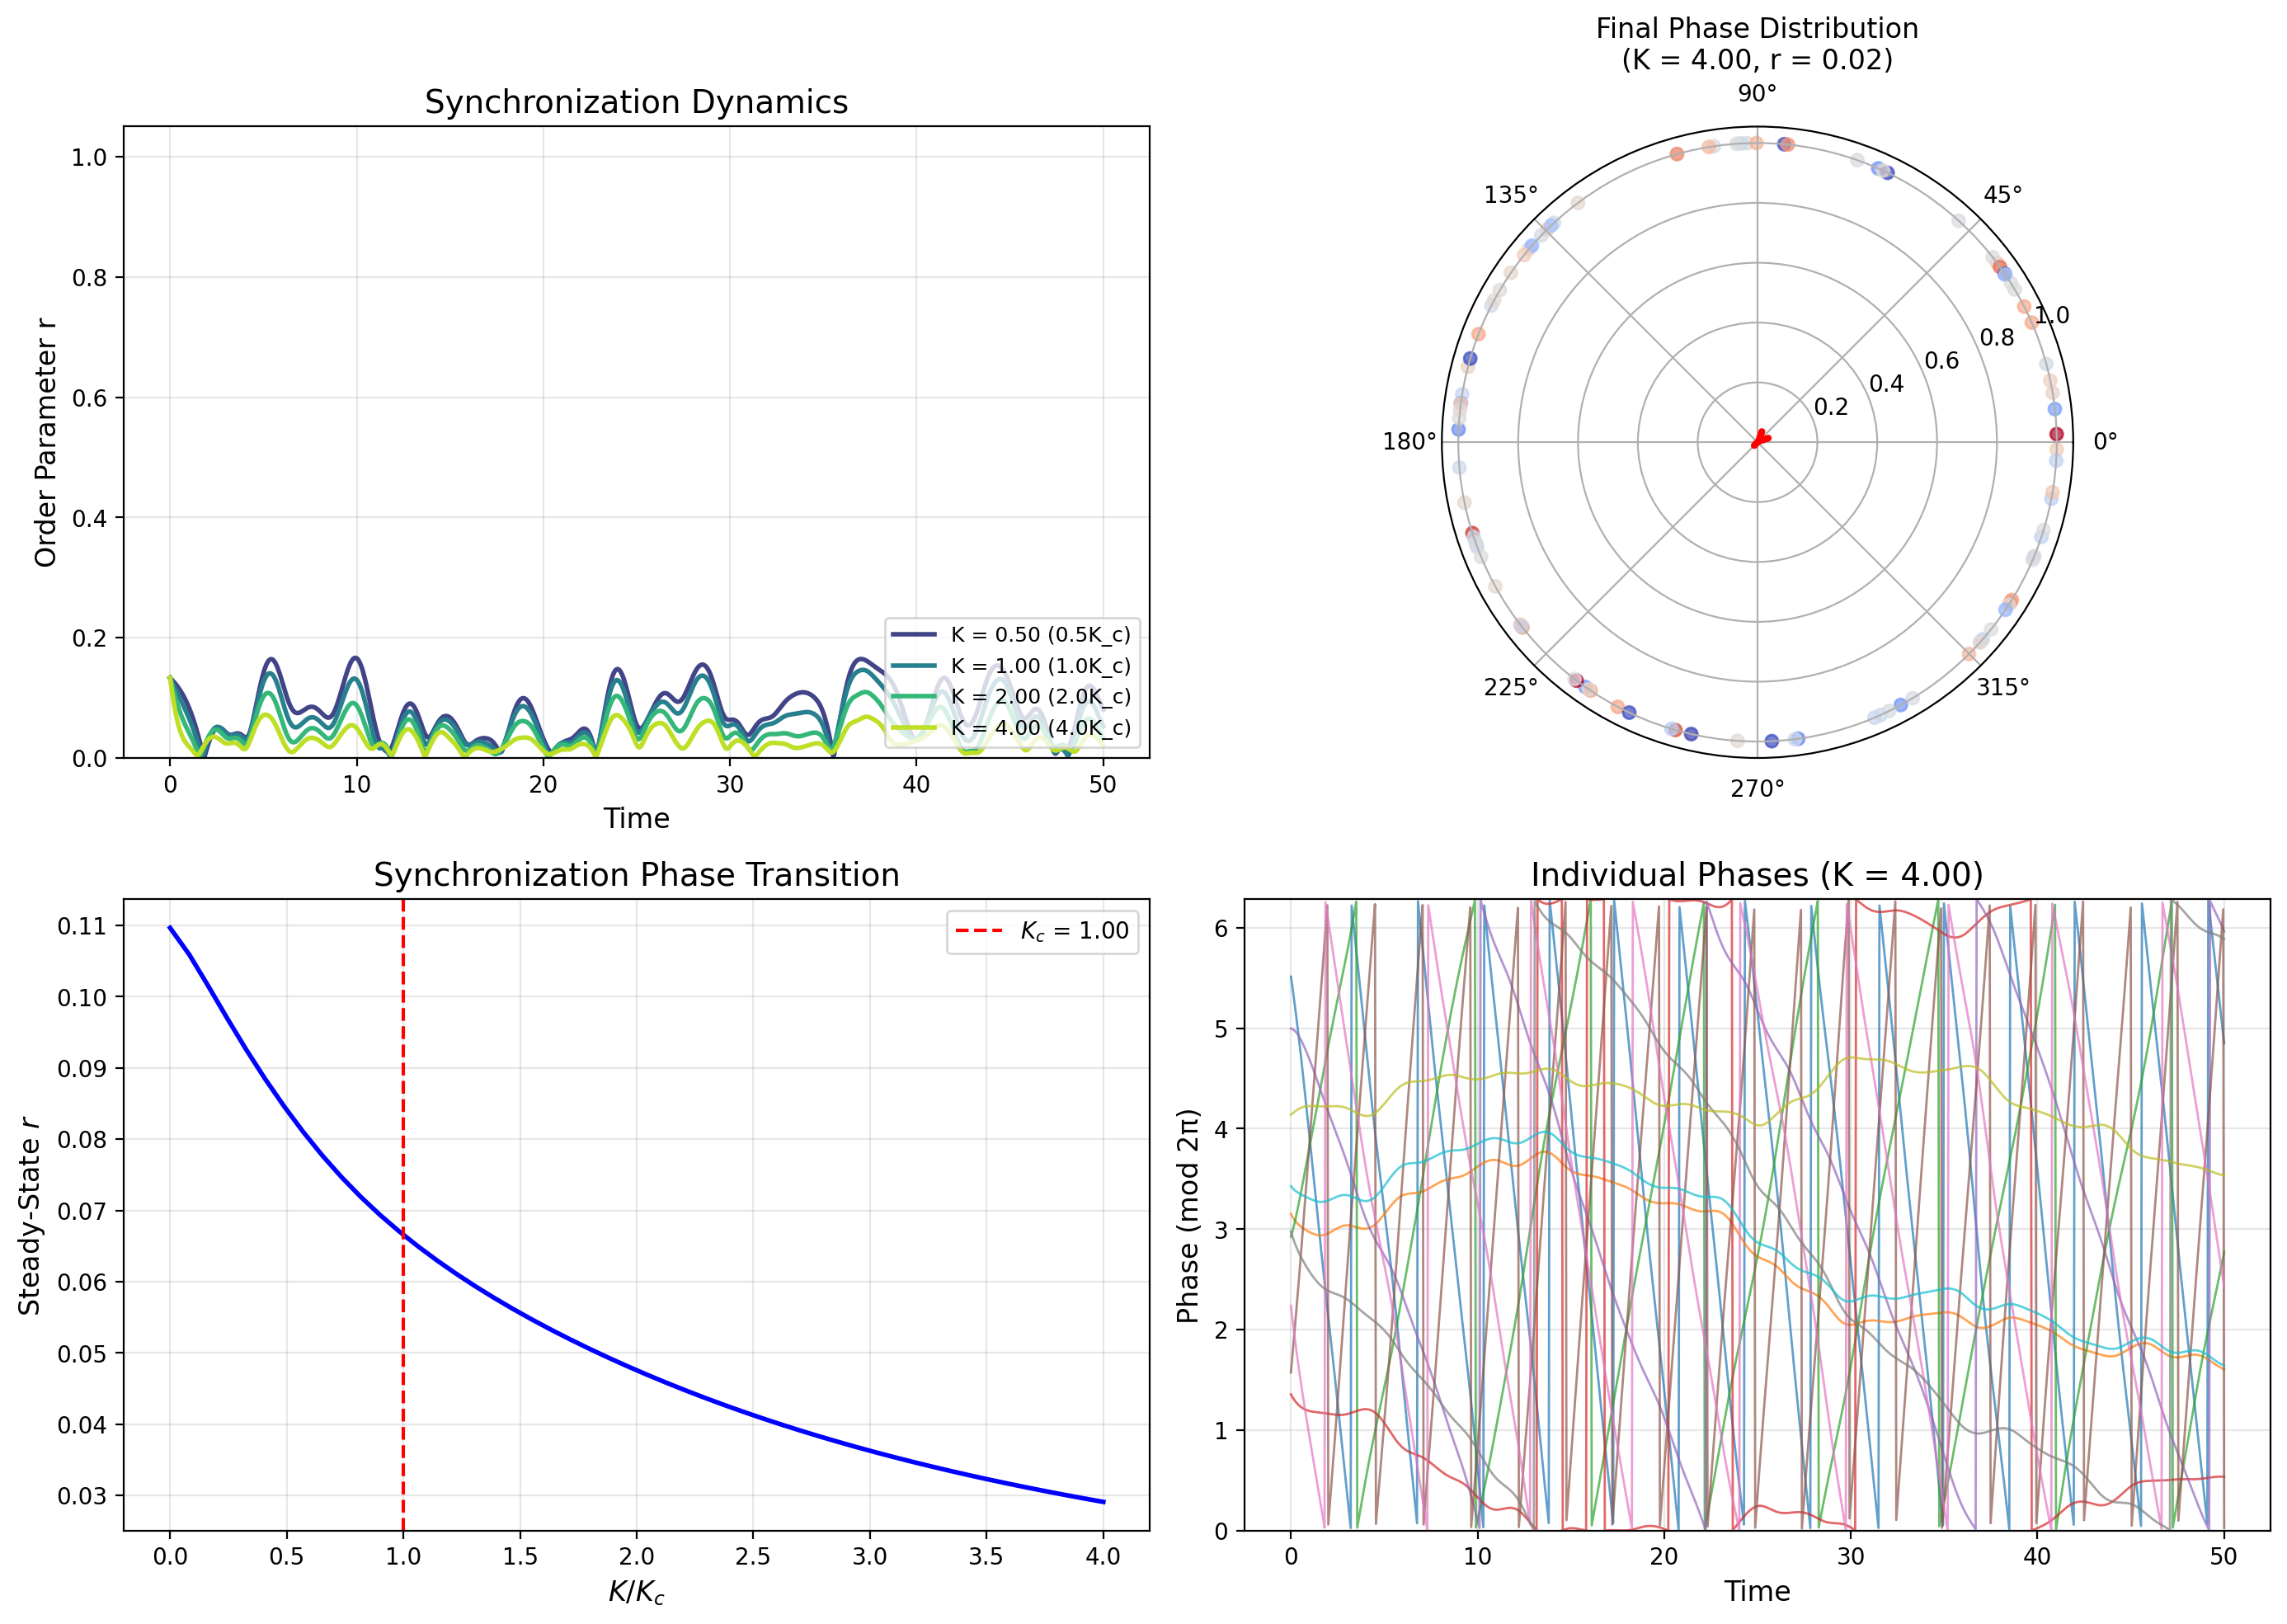


Plot saved to 'kuramoto_model_synchronization_comprehensive_analysis.png'


In [5]:
# Create comprehensive visualization
fig = plt.figure(figsize=(14, 10))

# Plot 1: Order parameter evolution
ax1 = fig.add_subplot(2, 2, 1)
colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(K_values)))
for i, (r, label) in enumerate(zip(order_params, labels)):
    ax1.plot(t, r, color=colors[i], label=label, linewidth=2)
ax1.set_xlabel('Time', fontsize=12)
ax1.set_ylabel('Order Parameter r', fontsize=12)
ax1.set_title('Synchronization Dynamics', fontsize=14)
ax1.legend(loc='lower right', fontsize=9)
ax1.set_ylim(0, 1.05)
ax1.grid(True, alpha=0.3)

# Plot 2: Phase distribution snapshots (polar plot)
ax2 = fig.add_subplot(2, 2, 2, projection='polar')
# Show final state for strongest coupling
theta_final = results[-1][-1] % (2*np.pi)
ax2.scatter(theta_final, np.ones(N), c=omega, cmap='coolwarm', s=30, alpha=0.7)
# Show order parameter
r_final = order_params[-1][-1]
psi_final = np.angle(np.mean(np.exp(1j * theta_final)))
ax2.annotate('', xy=(psi_final, r_final), xytext=(0, 0),
             arrowprops=dict(arrowstyle='->', color='red', lw=3))
ax2.set_title(f'Final Phase Distribution\n(K = {K_values[-1]:.2f}, r = {r_final:.2f})', fontsize=12)

# Plot 3: Phase transition curve
ax3 = fig.add_subplot(2, 2, 3)
K_range = np.linspace(0, 4*K_c, 50)
r_steady = []

for K in K_range:
    theta = odeint(kuramoto_ode, theta0, t, args=(omega, K, N))
    r, _ = compute_order_parameter(theta)
    # Average over last 20% of time
    r_steady.append(np.mean(r[-200:]))

ax3.plot(K_range/K_c, r_steady, 'b-', linewidth=2)
ax3.axvline(x=1, color='r', linestyle='--', label=f'$K_c$ = {K_c:.2f}')
ax3.set_xlabel('$K/K_c$', fontsize=12)
ax3.set_ylabel('Steady-State $r$', fontsize=12)
ax3.set_title('Synchronization Phase Transition', fontsize=14)
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# Plot 4: Phase evolution (wrapped) for subcritical vs supercritical
ax4 = fig.add_subplot(2, 2, 4)
# Show 10 oscillators for clarity
n_show = 10
idx_show = np.linspace(0, N-1, n_show, dtype=int)

# Supercritical case
theta_super = results[-1][:, idx_show] % (2*np.pi)
for i in range(n_show):
    ax4.plot(t, theta_super[:, i], alpha=0.7, linewidth=1)
ax4.set_xlabel('Time', fontsize=12)
ax4.set_ylabel('Phase (mod 2π)', fontsize=12)
ax4.set_title(f'Individual Phases (K = {K_values[-1]:.2f})', fontsize=14)
ax4.set_ylim(0, 2*np.pi)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('kuramoto_model_synchronization_comprehensive_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to 'kuramoto_model_synchronization_comprehensive_analysis.png'")

## Analysis and Discussion

### Key Observations

1. **Phase Transition**: The system exhibits a clear phase transition at $K = K_c$. Below this threshold, oscillators remain desynchronized ($r \approx 0$); above it, coherent behavior emerges.

2. **Order Parameter Dynamics**: For supercritical coupling ($K > K_c$), the order parameter grows from near zero to a steady-state value, demonstrating the emergence of collective synchronization.

3. **Partial Synchronization**: Even for $K > K_c$, perfect synchronization ($r = 1$) is not achieved because oscillators with frequencies far from the mean cannot lock to the collective rhythm.

4. **Mean-Field Nature**: The order parameter acts as a mean field that mediates interactions—oscillators effectively couple to the collective rhythm rather than to each individual oscillator.

### Applications

The Kuramoto model provides insights into:
- **Neuroscience**: Neural synchronization and brain rhythms
- **Circadian rhythms**: Synchronization of biological clocks
- **Power grids**: Frequency synchronization of generators
- **Chemical oscillators**: Belousov-Zhabotinsky reaction synchronization
- **Social dynamics**: Opinion formation and consensus

## References

1. Kuramoto, Y. (1975). Self-entrainment of a population of coupled non-linear oscillators. *International Symposium on Mathematical Problems in Theoretical Physics*, 39, 420-422.

2. Strogatz, S. H. (2000). From Kuramoto to Crawford: exploring the onset of synchronization in populations of coupled oscillators. *Physica D*, 143(1-4), 1-20.

3. Acebrón, J. A., et al. (2005). The Kuramoto model: A simple paradigm for synchronization phenomena. *Reviews of Modern Physics*, 77(1), 137.